### MITBIH Classifier

In [9]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shutil
from wfdb import processing
import wfdb
import pickle

file = np.unique(np.array(list(map(lambda x: x.split('.')[0], os.listdir("../../MITBIH"))))) # get file name

# file 100 error 
def readrecord(x):
    try:
        # scale
        rec = pd.DataFrame(preprocessing.scale(wfdb.rdsamp('../../MITBIH/'+x)[0]))
        r, f = wfdb.rdsamp('../../MITBIH/'+x, sampto=1)
        annotation = wfdb.rdann('../../MITBIH/'+x, 'atr')
        anno = [annotation.__dict__['symbol'],annotation.__dict__['sample']]
        field = f['comments'][0].split(' ')
        lead = f['sig_name']
        age = field[0]
        peak = readPeak(rec[0])
        gender = field[1]
        pvc = countPVC(anno)
        p2p_mean = np.average((np.append(peak,0)-np.append(0,peak))[1:-1])
        p2p_std = np.std((np.append(peak,0)-np.append(0,peak))[1:-1])
    except ValueError:
#         print(x + ' :error')
        rec = None
    else:
#         print(x + ' :succeed' + ' :' + str(abnormalCheck(anno)))
        return {'id':x,'rec':rec,'PVC':pvc,'anno' :anno,'lead':lead,'age':age,'peak':peak, 'gender':gender,'p2p_mean': p2p_mean,'p2p_std': p2p_std}

    # check abnormal, not PVC yet
def readPeak(x):    
    peak = wfdb.processing.find_peaks(np.array(x)) # wfdb function to find peak
    meanp = np.average(x[peak[0]])
    sdp = np.std(x[peak[0]])
    return x[peak[0]][x[peak[0]]> meanp + 4*sdp].index.values
    
def abnormalCheck(x):
    if (len(set(x[0])) > 1):
        return True
    else:
        return False
    
def countPVC(x):
    try:
        c = x[0].count('V')
    except ValueError:
        return 0
    else:
        return c


#### The annotation data are kept in .atr file. The index is the time when the abnormal beat occur

In [10]:
annotation = wfdb.rdann('../../MITBIH/'+'101', 'atr')
anno = [annotation.__dict__['symbol'],annotation.__dict__['sample']]
tmp = pd.DataFrame(data=anno[0],index=anno[1],columns=['symbol'])
tmp.head()

,symbol
7,+
83,N
396,N
711,N
1032,N


### Read data

In [11]:
MITBIH = np.array(list(map(readrecord, file)))
MITBIH = MITBIH[~(MITBIH == None)] # filter data that connot read

In [12]:
# pickle.dump( MITBIH, open( "MITBIH.p", "wb") )

In [13]:
pvc = MITBIH[np.array([i['PVC'] for i in MITBIH]) > 0]
normal = MITBIH[np.array([i['PVC'] for i in MITBIH]) == 0]

In [14]:
# select patients that have PVC alarm more than 10
new_pvc = pvc[np.array([i['PVC'] for i in pvc]) >= 10]
print(len(new_pvc))
# split into test and train by patient
import random
random = np.array(random.sample(range(1, 17), 10))
train_pvc = new_pvc[random]
test_pvc = new_pvc[~random]

27


In [ ]:
# balance data
# np.array([i['PVC'] for i in train_pvc])
# [i for i in list(range(1,int(len(train_pvc[0]['rec'])/interval)))]


In [185]:
interval = 3600 # 25mm = 1s


def getAnn(x,i):
    """get annotation of each time windows"""
    tmp = pd.DataFrame(data=x[0],index=x[1],columns=['symbol'])
    return tmp[(tmp.index.values > (i-1)*interval) & (tmp.index.values < (i)*interval)]
def getPeak(x,i):
    """get Peak of each time window
    getPeak(x,i)
    x = dataframe of
    i = i * 3600 - (i+1) * 3600 windows
    """
    return x[(x > (i-1)*interval) & (x < (i)*interval)]
def findPVC(x,i):
    tmp = pd.DataFrame(data=x[0],index=x[1],columns=['symbol'])
    tmp2 = tmp[(tmp.index.values > (i-1)*interval) & (tmp.index.values < (i)*interval)]
    return any(tmp2['symbol'] == 'V')

def sliceData(x):
    # slice data into 10 second unit
    return [{'id': x['id'],
             'age':x['age'],
             'gender':(0, 1)[x['gender'] == 'F'],
             'p2p_mean':x['p2p_mean'],
             'p2p_std':x['p2p_std'],
             'R_interval_mean': np.average((np.append(getAnn(x['anno'],i).index.values,0)-np.append(0,getAnn(x['anno'],i).index.values))[1:-1]),
             'R_interval_sd': np.std((np.append(getAnn(x['anno'],i).index.values,0)-np.append(0,getAnn(x['anno'],i).index.values))[1:-1]),
             'peak': getPeak(x['peak'],i),
            # 'PVC':x['PVC'],
             'stripPVC':findPVC(x['anno'],i), 
             'lead':x['lead'],
            'strip': pd.DataFrame(
                data = np.transpose([x['rec'].iloc[(i-1)*interval:(i*interval)].iloc[:,0], x['rec'].iloc[(i-1)*interval:(i*interval)].iloc[:,1]]),
                index= np.array(range((i-1)*interval,(i*interval)))
            ),
            'annotation':getAnn(x['anno'],i)            
            } for i in list(range(1,int(len(x['rec'])/interval)))]

def rebase(signal):
    """ 
    Fix the wandering baseline with average smoothing. 
  
    Parameters: 
    signal (pandas dataframe): input signal with the right index 
  
    Returns: 
    int: pandas dataframe
  
    """
    import pandas as pd
    import numpy as np

    window = 150
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(np.array(signal).flatten(), weights, 'same')
    rebase = pd.DataFrame(np.array(signal).flatten()-sma,index = signal.index.values).copy()

    return rebase

def wavelet_smooth(original, family="db4"):
  
    """ 
    Smoothing signal with wavelet transform.
  
    Parameters: 
    original (series): input signal with the right index 
  
    Returns: 
    list : list of newsignal 
  
    """
    import numpy as np
    inputdat = np.array(original)
    import pywt
    
    import pandas as pd
    import matplotlib.pyplot as plt
    c = pywt.swt(np.array(inputdat), family, level=3)
    c_h2 = pywt.threshold(c, 0.1, mode='hard', substitute=0)
    i = pd.DataFrame(pywt.iswt(c_h2, family),index=original.index.values)
    return(i)

In [20]:
# slice signal into 10 second window. To analyze premature. We have to compare with the baseline

MITBIH_slice = list(map(sliceData,train_pvc))
test_slice = list(map(sliceData,test_pvc))

In [187]:
# balance dataset
# [MITBIH_slice[0][(MITBIH_slice[0][j]['stripPVC']) == True] for j in list(range(1,len(MITBIH_slice)))] 
# np.array([i['stripPVC'] for i in MITBIH_slice])

dataset =  pd.DataFrame.from_records(np.array(MITBIH_slice).flatten())
testset = pd.DataFrame.from_records(np.array(test_slice).flatten())


In [188]:
# get only lead V1
dataset['lead'] = [x[1] for x in dataset['lead']]
dataset = dataset[dataset['lead']=='V1']
dataset.strip = [x[1] for x in dataset['strip']]
print('is PVC ' + str(len(dataset[dataset['stripPVC'] == True])))
print('is normal ' + str(len(dataset[dataset['stripPVC'] == False])))
dataset.head()

testset['lead'] = [x[1] for x in testset['lead']]
testset = testset[testset['lead']=='V1']
testset.strip = [x[1] for x in testset['strip']]
print('is PVC ' + str(len(testset[testset['stripPVC'] == True])))
print('is normal ' + str(len(testset[testset['stripPVC'] == False])))


is PVC 719
is normal 713
is PVC 887
is normal 903


In [42]:
# pickle.dump( dataset, open( "trainset.p", "wb") )
# pickle.dump( testset, open( "testset.p", "wb") )

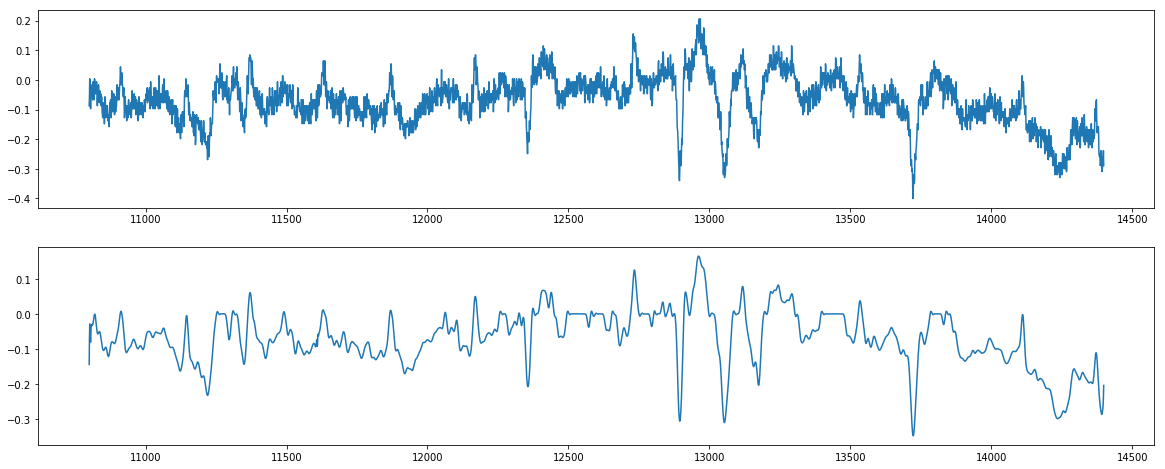

In [189]:

# smooth by wavelet transform
plt.figure(figsize=(20,8))
plt.subplot(2, 1, 1)
plt.plot(dataset.iloc[3].strip)
dataset.strip = [wavelet_smooth(x) for x in dataset['strip']]
plt.subplot(2, 1, 2)
plt.plot(dataset.iloc[3].strip)

testset.strip = [wavelet_smooth(x) for x in testset['strip']]


### Daubechies wavelet 
![](http://matlab.izmiran.ru/help/toolbox/wavelet/ch01_i48.gif)

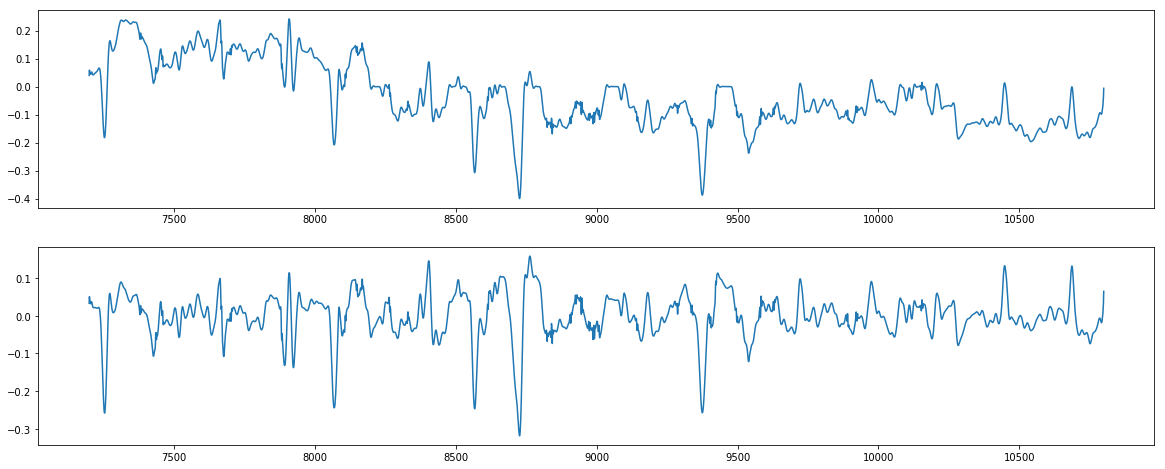

In [190]:
# rebase
plt.figure(figsize=(20,8))
plt.subplot(2, 1, 1)
plt.plot(dataset.iloc[2].strip)
dataset.strip = [rebase(x) for x in dataset['strip']]
plt.subplot(2, 1, 2)
plt.plot(dataset.iloc[2].strip)

testset.strip = [rebase(x) for x in testset['strip']]

In [199]:
print(len(dataset[dataset['stripPVC'] == True]))
print(len(dataset[dataset['stripPVC'] == False]))
print(len(testset[testset['stripPVC'] == True]))
print(len(testset[testset['stripPVC'] == False]))

719
713
887
903


In [200]:
import random
train = dataset[dataset['stripPVC'] == True].append(dataset[dataset['stripPVC'] == False])
train['p2p_diff_form_norm'] =  abs(train['p2p_mean'] - train['R_interval_mean'])

test = testset[testset['stripPVC'] == True].append(testset[testset['stripPVC'] == False])
test['p2p_diff_form_norm'] =  abs(test['p2p_mean'] - test['R_interval_mean'])

In [201]:
pickle.dump( dataset, open( "trainset.p", "wb") )
pickle.dump( testset, open( "testset.p", "wb") )

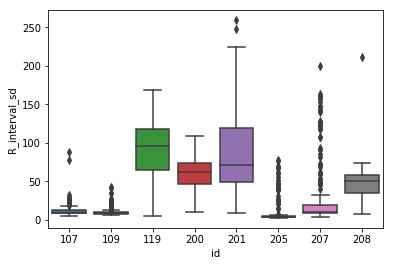

In [202]:
import seaborn as sns
sns.boxplot(y = 'R_interval_sd',x='id', data = dataset)

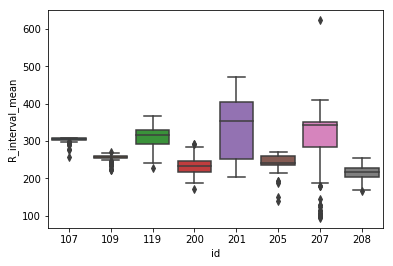

In [203]:
sns.boxplot(y = 'R_interval_mean',x='id', data = dataset)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(train.drop(['peak','annotation','strip','stripPVC'], axis=1) , train['stripPVC'])
pred = clf.predict(test.drop(['peak','annotation','strip','stripPVC'], axis=1))

In [ ]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(pred,test['stripPVC']), columns=['True','False'], index=['True','False'])

In [ ]:
plt.plot(MITBIH[1]['rec'][639998:649998][0])
MITBIH[1]['peak']

In [ ]:
print(MITBIH[1]['rec'][0][639998])

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(pred,test['stripPVC'])